## Eye State Classification from EEG


### Introduction


### Data Prep



In [1]:
# setting the random seed for reproducibility
import random
seed=42
random.seed(seed)

In [2]:
# import libraries 
import itertools
import requests
import os.path
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

### Load the Data

In [3]:
# check if data file exists locally
if not os.path.isfile('EEG Eye State.arff'):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff'
    r = requests.get(url, allow_redirects=True)
    open('EEG Eye State.arff', 'wb').write(r.content)

# read data from local csv file
#df = pd.read_csv("EEGEyeState.csv", header=None)

# read data from local arff file
data = arff.loadarff('EEG Eye State.arff')
df = pd.DataFrame(data[0])

In [4]:
# reject NaN entries
df.dropna()

# insert columns names
df.columns = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'eyeDetection']

# remove outliers
df1 = df[df.loc[:, df.columns != 'eyeDetection'].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

# define data samples
X = df1.iloc[0:, 0:14].values

# standardize data
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_short = min_max_scaler.fit_transform(X)

# define target
y_short = df1.iloc[0:,14].values.astype(int)

unique, counts = np.unique(y_short, return_counts=True)
print(dict(zip(unique, counts)))

print(df.shape)
print(X_short,X_short.shape,'\n\n',
      y_short,y_short.shape)

{0: 8172, 1: 6720}
(14980, 15)
[[0.43315296 0.42978053 0.53914831 ... 0.44283486 0.52808589 0.51187141]
 [0.41794246 0.41065428 0.56628488 ... 0.43715177 0.51965054 0.48535451]
 [0.4280718  0.41915944 0.57527166 ... 0.4514152  0.50842166 0.49930648]
 ...
 [0.26227399 0.35319255 0.289163   ... 0.3171384  0.4072796  0.36402948]
 [0.2859641  0.35742439 0.31624082 ... 0.36856474 0.41993263 0.3947075 ]
 [0.29609344 0.38086545 0.36745962 ... 0.4085692  0.4241503  0.3947075 ]] (14892, 14) 

 [0 0 0 ... 1 1 1] (14892,)


### Model



In [5]:
# full dataset parameters

# define model parameters
samples = X_short.shape[0]  # how many trials of eeg data
n_features = X_short.shape[1]  # how many channels of eeg in each sample
time_steps = 1 # how many ms was each sample run for

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

# use strat. shuffle split to get indices for test and training data 
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=seed)
sss.get_n_splits(X_short, y_short)

# take the indices generated by stratified shuffle split and make the test and training datasets
for train_index, test_index in sss.split(X_short, y_short):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_short[train_index], X_short[test_index]
    y_train, y_test = y_short[train_index], y_short[test_index]
    
X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0], time_steps)

X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], time_steps)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, TerminateOnNaN

model = Sequential()
model.add(Bidirectional(LSTM(28, return_sequences=True, 
               recurrent_regularizer=l1_l2(0.0001, 0.0001),
               input_shape=(time_steps, n_features))))
model.add(Bidirectional(LSTM(28, input_shape=(time_steps, n_features), 
               recurrent_regularizer=l1_l2(0.0001, 0.0001),
               return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(28, input_shape=(time_steps, n_features),
              recurrent_regularizer=l1_l2(0.0001, 0.0001))))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')

terminate_NaN = TerminateOnNaN()

history = model.fit(X_train, y_train, validation_split=0.25, 
                    batch_size=28, epochs=1000, verbose=1, 
                    callbacks=[early_stop, terminate_NaN])

Train on 8934 samples, validate on 2979 samples
Epoch 1/1000
8934/8934 [==============================] - 15s 2ms/step - loss: 0.6964 - acc: 0.5647 - val_loss: 0.7201 - val_acc: 0.5680
Epoch 2/1000
8934/8934 [==============================] - 6s 705us/step - loss: 0.6542 - acc: 0.6126 - val_loss: 0.6663 - val_acc: 0.6059
Epoch 3/1000
8934/8934 [==============================] - 6s 707us/step - loss: 0.6416 - acc: 0.6255 - val_loss: 0.6332 - val_acc: 0.6217
Epoch 4/1000
8934/8934 [==============================] - 6s 710us/step - loss: 0.6240 - acc: 0.6328 - val_loss: 0.6419 - val_acc: 0.6066
Epoch 5/1000
8934/8934 [==============================] - 6s 716us/step - loss: 0.5997 - acc: 0.6667 - val_loss: 0.6669 - val_acc: 0.6254
Epoch 6/1000
8934/8934 [==============================] - 6s 717us/step - loss: 0.5652 - acc: 0.6980 - val_loss: 0.5475 - val_acc: 0.7006
Epoch 7/1000
8934/8934 [==============================] - 6s 703us/step - loss: 0.5348 - acc: 0.7319 - val_loss: 0.5245 - val

Epoch 60/1000
8934/8934 [==============================] - 7s 801us/step - loss: 0.2866 - acc: 0.8743 - val_loss: 0.2849 - val_acc: 0.8741
Epoch 61/1000
8934/8934 [==============================] - 7s 794us/step - loss: 0.2846 - acc: 0.8767 - val_loss: 0.2998 - val_acc: 0.8681
Epoch 62/1000
8934/8934 [==============================] - 7s 812us/step - loss: 0.2847 - acc: 0.8772 - val_loss: 0.2785 - val_acc: 0.8815
Epoch 63/1000
8934/8934 [==============================] - 7s 824us/step - loss: 0.2807 - acc: 0.8809 - val_loss: 0.2820 - val_acc: 0.8798
Epoch 64/1000
8934/8934 [==============================] - 7s 805us/step - loss: 0.2815 - acc: 0.8784 - val_loss: 0.2752 - val_acc: 0.8818
Epoch 65/1000
8934/8934 [==============================] - 7s 804us/step - loss: 0.2808 - acc: 0.8770 - val_loss: 0.2864 - val_acc: 0.8684
Epoch 66/1000
8934/8934 [==============================] - 7s 810us/step - loss: 0.2781 - acc: 0.8791 - val_loss: 0.3016 - val_acc: 0.8651
Epoch 67/1000
8934/8934 [==

Epoch 119/1000
8934/8934 [==============================] - 8s 861us/step - loss: 0.2100 - acc: 0.9136 - val_loss: 0.2745 - val_acc: 0.8849
Epoch 120/1000
8934/8934 [==============================] - 7s 824us/step - loss: 0.2156 - acc: 0.9082 - val_loss: 0.2181 - val_acc: 0.9100
Epoch 121/1000
8934/8934 [==============================] - 7s 808us/step - loss: 0.2053 - acc: 0.9171 - val_loss: 0.1896 - val_acc: 0.9235
Epoch 122/1000
8934/8934 [==============================] - 7s 823us/step - loss: 0.2045 - acc: 0.9161 - val_loss: 0.2024 - val_acc: 0.9154
Epoch 123/1000
8934/8934 [==============================] - 7s 825us/step - loss: 0.2094 - acc: 0.9121 - val_loss: 0.2084 - val_acc: 0.9094
Epoch 124/1000
8934/8934 [==============================] - 7s 824us/step - loss: 0.1998 - acc: 0.9168 - val_loss: 0.1806 - val_acc: 0.9278
Epoch 125/1000
8934/8934 [==============================] - 7s 812us/step - loss: 0.1992 - acc: 0.9161 - val_loss: 0.1996 - val_acc: 0.9218
Epoch 126/1000
8934/

8934/8934 [==============================] - 7s 807us/step - loss: 0.1699 - acc: 0.9304 - val_loss: 0.1589 - val_acc: 0.9369
Epoch 178/1000
8934/8934 [==============================] - 7s 815us/step - loss: 0.1629 - acc: 0.9338 - val_loss: 0.1513 - val_acc: 0.9399
Epoch 179/1000
8934/8934 [==============================] - 7s 813us/step - loss: 0.1710 - acc: 0.9276 - val_loss: 0.1491 - val_acc: 0.9406
Epoch 180/1000
8934/8934 [==============================] - 7s 798us/step - loss: 0.1646 - acc: 0.9305 - val_loss: 0.1697 - val_acc: 0.9302
Epoch 181/1000
8934/8934 [==============================] - 7s 801us/step - loss: 0.1616 - acc: 0.9335 - val_loss: 0.1523 - val_acc: 0.9429
Epoch 182/1000
8934/8934 [==============================] - 7s 817us/step - loss: 0.1684 - acc: 0.9335 - val_loss: 0.1548 - val_acc: 0.9349
Epoch 183/1000
8934/8934 [==============================] - 7s 819us/step - loss: 0.1571 - acc: 0.9362 - val_loss: 0.1593 - val_acc: 0.9352
Epoch 184/1000
8934/8934 [=========

8934/8934 [==============================] - 7s 816us/step - loss: 0.1383 - acc: 0.9459 - val_loss: 0.1533 - val_acc: 0.9429
Epoch 236/1000
8934/8934 [==============================] - 7s 813us/step - loss: 0.1315 - acc: 0.9476 - val_loss: 0.1384 - val_acc: 0.9409
Epoch 237/1000
8934/8934 [==============================] - 7s 819us/step - loss: 0.1454 - acc: 0.9426 - val_loss: 0.1372 - val_acc: 0.9423
Epoch 238/1000
8934/8934 [==============================] - 7s 813us/step - loss: 0.1385 - acc: 0.9454 - val_loss: 0.1340 - val_acc: 0.9473
Epoch 239/1000
8934/8934 [==============================] - 7s 812us/step - loss: 0.1329 - acc: 0.9475 - val_loss: 0.1443 - val_acc: 0.9433
Epoch 240/1000
8934/8934 [==============================] - 7s 819us/step - loss: 0.1493 - acc: 0.9420 - val_loss: 0.1299 - val_acc: 0.9490
Epoch 241/1000
8934/8934 [==============================] - 7s 818us/step - loss: 0.1301 - acc: 0.9480 - val_loss: 0.1381 - val_acc: 0.9473
Epoch 242/1000
8934/8934 [=========

8934/8934 [==============================] - 6s 718us/step - loss: 0.1163 - acc: 0.9530 - val_loss: 0.1428 - val_acc: 0.9436
Epoch 294/1000
8934/8934 [==============================] - 6s 644us/step - loss: 0.1274 - acc: 0.9488 - val_loss: 0.1420 - val_acc: 0.9453
Epoch 295/1000
8934/8934 [==============================] - 6s 636us/step - loss: 0.1341 - acc: 0.9482 - val_loss: 0.1359 - val_acc: 0.9493
Epoch 296/1000
8934/8934 [==============================] - 6s 633us/step - loss: 0.1204 - acc: 0.9535 - val_loss: 0.1216 - val_acc: 0.9490
Epoch 297/1000
8934/8934 [==============================] - 6s 644us/step - loss: 0.1160 - acc: 0.9550 - val_loss: 0.1284 - val_acc: 0.9480
Epoch 298/1000
8934/8934 [==============================] - 6s 641us/step - loss: 0.1271 - acc: 0.9492 - val_loss: 0.1176 - val_acc: 0.9550
Epoch 299/1000
8934/8934 [==============================] - 6s 636us/step - loss: 0.1140 - acc: 0.9546 - val_loss: 0.1240 - val_acc: 0.9537
Epoch 300/1000
8934/8934 [=========

8934/8934 [==============================] - 6s 632us/step - loss: 0.1041 - acc: 0.9610 - val_loss: 0.1302 - val_acc: 0.9550
Epoch 352/1000
8934/8934 [==============================] - 6s 629us/step - loss: 0.1071 - acc: 0.9585 - val_loss: 0.1267 - val_acc: 0.9533
Epoch 353/1000
8934/8934 [==============================] - 6s 625us/step - loss: 0.1041 - acc: 0.9566 - val_loss: 0.1206 - val_acc: 0.9574
Epoch 354/1000
8934/8934 [==============================] - 6s 632us/step - loss: 0.1095 - acc: 0.9572 - val_loss: 0.1018 - val_acc: 0.9644
Epoch 355/1000
8934/8934 [==============================] - 6s 631us/step - loss: 0.1048 - acc: 0.9610 - val_loss: 0.1075 - val_acc: 0.9597
Epoch 356/1000
8934/8934 [==============================] - 6s 628us/step - loss: 0.1021 - acc: 0.9621 - val_loss: 0.1207 - val_acc: 0.9564
Epoch 357/1000
8934/8934 [==============================] - 6s 634us/step - loss: 0.1072 - acc: 0.9587 - val_loss: 0.1209 - val_acc: 0.9550
Epoch 358/1000
8934/8934 [=========

8934/8934 [==============================] - 5s 515us/step - loss: 0.1007 - acc: 0.9606 - val_loss: 0.0996 - val_acc: 0.9634
Epoch 410/1000
8934/8934 [==============================] - 5s 505us/step - loss: 0.0928 - acc: 0.9637 - val_loss: 0.1269 - val_acc: 0.9584
Epoch 411/1000
8934/8934 [==============================] - 4s 500us/step - loss: 0.1006 - acc: 0.9600 - val_loss: 0.1070 - val_acc: 0.9654
Epoch 412/1000
8934/8934 [==============================] - 5s 518us/step - loss: 0.0912 - acc: 0.9633 - val_loss: 0.1066 - val_acc: 0.9624
Epoch 413/1000
8934/8934 [==============================] - 4s 452us/step - loss: 0.0909 - acc: 0.9649 - val_loss: 0.1155 - val_acc: 0.9584
Epoch 414/1000
8934/8934 [==============================] - 4s 412us/step - loss: 0.0955 - acc: 0.9626 - val_loss: 0.1321 - val_acc: 0.9530
Epoch 415/1000
8934/8934 [==============================] - 4s 411us/step - loss: 0.0966 - acc: 0.9628 - val_loss: 0.1029 - val_acc: 0.9654
Epoch 416/1000
8934/8934 [=========

In [8]:
score = model.evaluate(X_test, y_test, batch_size=28)
score

2979/2979 [==============================] - 0s 96us/step


[0.12345518847128996, 0.9570325621425325]

In [9]:
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 95.70%


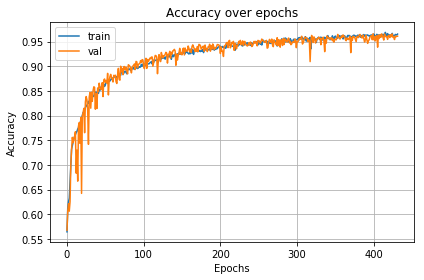

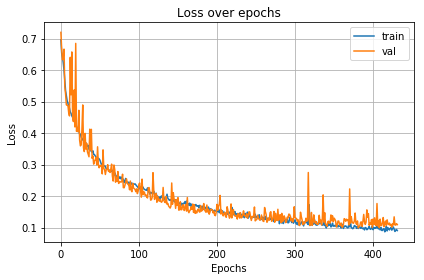

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.grid(True, which='both', axis='both')

# plt.minorticks_on()
plt.tight_layout()

plt.legend()
plt.show()

plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True, which='both', axis='both')
plt.tight_layout()
plt.legend()
plt.show()

# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [13]:
from keras.models import load_model

model.save('eeg_eye_state_model_blstm.h5')  # creates a HDF5 file 'my_model.h5'

# model = load_model('eeg_eye_state_model_blstm.h5')


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict_classes(X_test)
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.946
Recall: 0.960
F1: 0.953


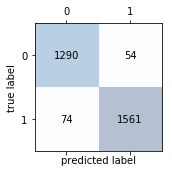

In [15]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
#print(confmat)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

ROC AUC: 0.957
Accuracy: 0.957


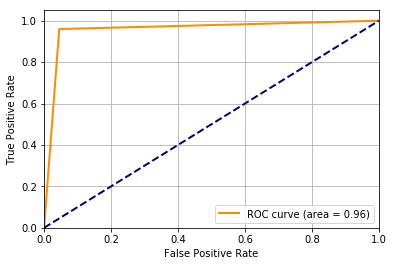

In [16]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2

plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

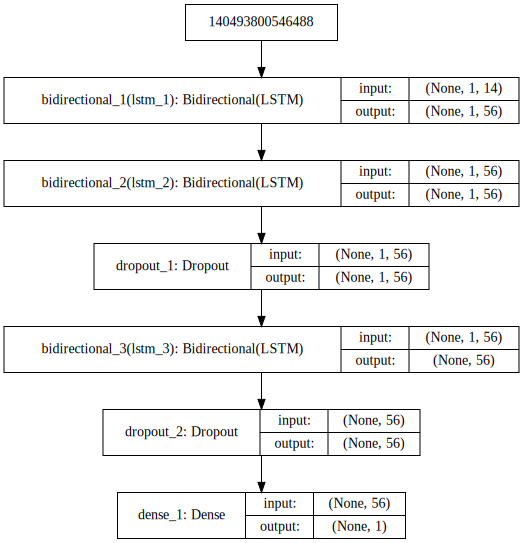

In [17]:
from keras.utils import plot_model
# plot_model(model, to_file='model.png')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))


In [18]:
from sklearn.metrics import classification_report
target_names = ['eye opened', 'eye closed']
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

              precision    recall  f1-score   support

  eye opened      0.967     0.955     0.961      1635
  eye closed      0.946     0.960     0.953      1344

   micro avg      0.957     0.957     0.957      2979
   macro avg      0.956     0.957     0.957      2979
weighted avg      0.957     0.957     0.957      2979



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.93')

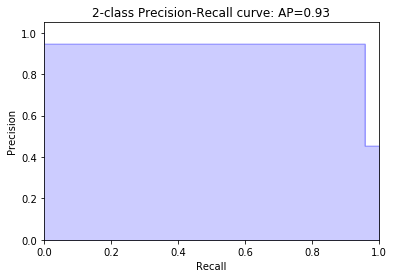

In [19]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 56)             9632      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 56)             19040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 56)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 56)                19040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 57        
Total params: 47,769
Trainable params: 47,769
Non-trainable params: 0
_________________________________________________________________
